<a href="https://colab.research.google.com/github/shery1010/Brain-Tumor-MRI-Image_project-/blob/main/Brain_Tumor_MRI_Image_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name - Brain Tumor MRI Image Classification

## Project Type: Classification

## Contribution - Individual

# Project Summary -

The Brain Tumor MRI Image Classification project aims to classify brain MRI scans into different tumor types using deep learning. It uses transfer learning (MobileNetV2) to improve accuracy and applies image preprocessing and augmentation to handle real-world variations. The model is deployed with a user-friendly Streamlit web app that allows users to upload MRI images and receive instant tumor type predictions.

This project combines medical imaging, AI, and web deployment to assist in early and accurate brain tumor detection.

# GitHub Link -

# Problem Statement -

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.


# 1. Know your data



In [1]:
from google.colab import files
uploaded = files.upload()


Saving train-20250723T131032Z-1-001.zip to train-20250723T131032Z-1-001.zip


# 2. Extract the data

In [2]:
import zipfile
import os

# Replace with your uploaded ZIP file name
zip_path = "/content/train-20250723T131032Z-1-001.zip"
extract_path = "unzipped_data"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Optional: list top-level folders
print("Unzipped folders:", os.listdir(extract_path))


Unzipped folders: ['train']


## Set Up the Directory Structure

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_data_dir = "unzipped_data/train"
base_dir = "brain_tumor_data"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Create folders
for path in [train_dir, val_dir]:
    if not os.path.exists(path):
        os.makedirs(path)

# Each subfolder is a class (e.g., glioma, meningioma, etc.)
for category in os.listdir(original_data_dir):
    category_path = os.path.join(original_data_dir, category)
    if not os.path.isdir(category_path):
        continue

    images = os.listdir(category_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create class folders
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
    for img in val_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

print("Train and validation folders created.")


Train and validation folders created.


# 3. Data Augmentation and Image Generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'brain_tumor_data/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'brain_tumor_data/val',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1355 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


## Visualize Augmented Images

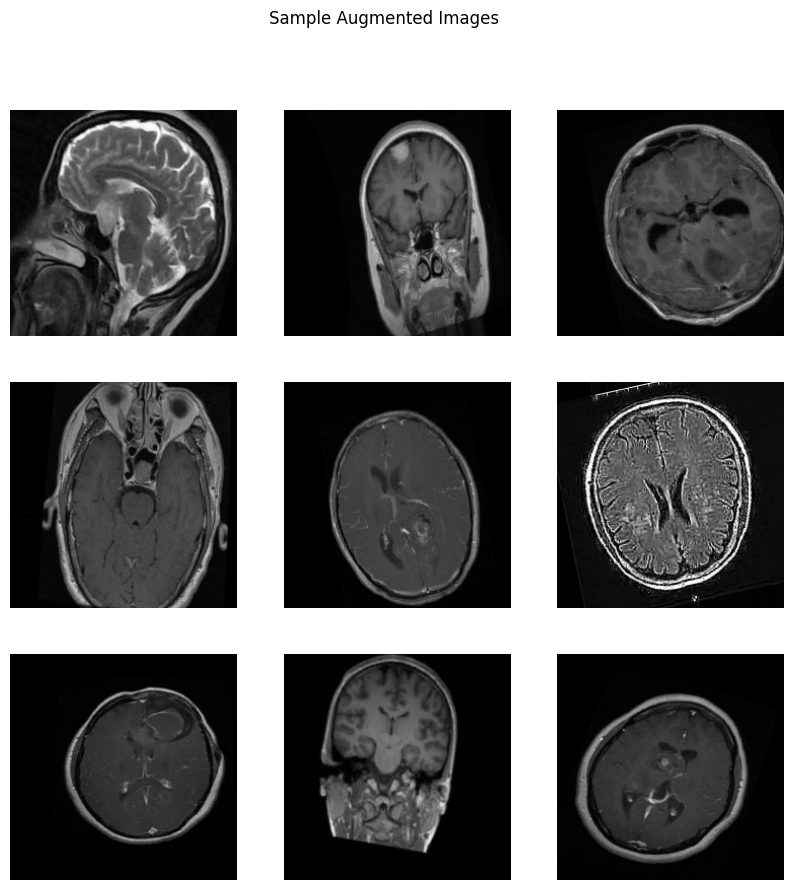

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of augmented images
x_batch, y_batch = next(train_generator)

# Plot 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle("Sample Augmented Images")
plt.show()


# 4. Model Building and Training

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Stop training early if no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.3605 - loss: 1.3430 - val_accuracy: 0.5559 - val_loss: 1.1074
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.5054 - loss: 1.2059 - val_accuracy: 0.6412 - val_loss: 0.9832
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.5686 - loss: 1.0567 - val_accuracy: 0.6559 - val_loss: 0.8810
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.6155 - loss: 0.9780 - val_accuracy: 0.6794 - val_loss: 0.8231
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.5491 - loss: 1.0527 - val_accuracy: 0.7353 - val_loss: 0.7247
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.6822 - loss: 0.8692 - val_accuracy: 0.7529 - val_loss: 0.6960
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.6826 - loss: 0.8491 - val_accuracy: 0.7235 - val_loss: 0.7273
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.7026 - loss: 0.7916 - val_accuracy: 0.7824 - v

## Visualize Training Results

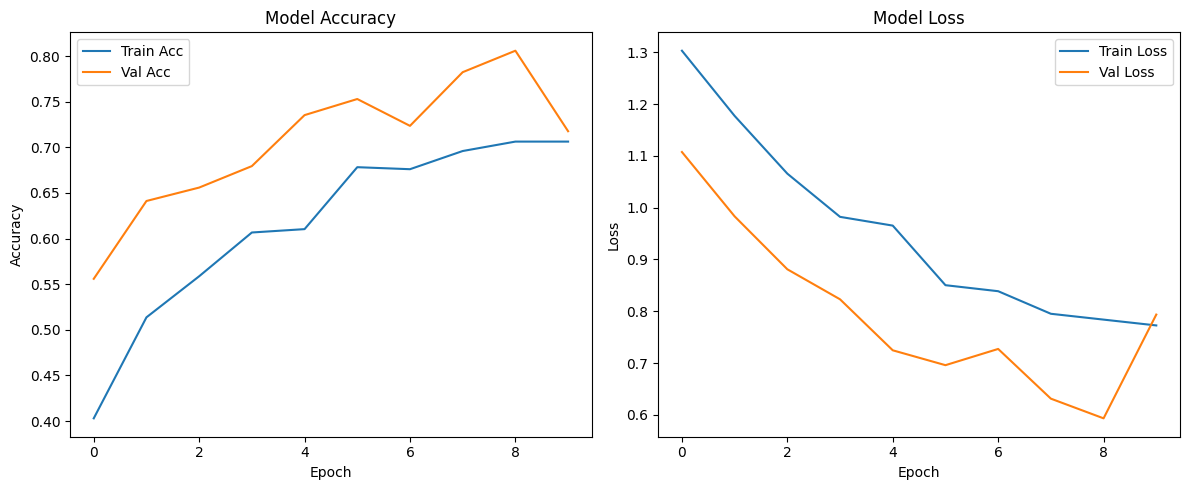

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 5. Transfer Learning(MobileNetV2)


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the convolutional base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6. Train the MobileNetV2 model

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mobilenet = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.2773 - loss: 1.7525 - val_accuracy: 0.6765 - val_loss: 0.9885
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5050 - loss: 1.1748 - val_accuracy: 0.7471 - val_loss: 0.7645
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6424 - loss: 0.9057 - val_accuracy: 0.8176 - val_loss: 0.6368
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6702 - loss: 0.7887 - val_accuracy: 0.7882 - val_loss: 0.5841
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7118 - loss: 0.7113 - val_accuracy: 0.7824 - val_loss: 0.5562
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7634 - loss: 0.6443 - val_accuracy: 0.7971 - val_loss: 0.5093
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7784 - loss: 0.6124 - val_accuracy: 0.8265 - val_loss: 0.4797
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7925 - loss: 0.5546 - val_accuracy: 0.8529 - val_

# 7. Model Evaluation (for both models)

## 1. Plot accuracy & loss curves:

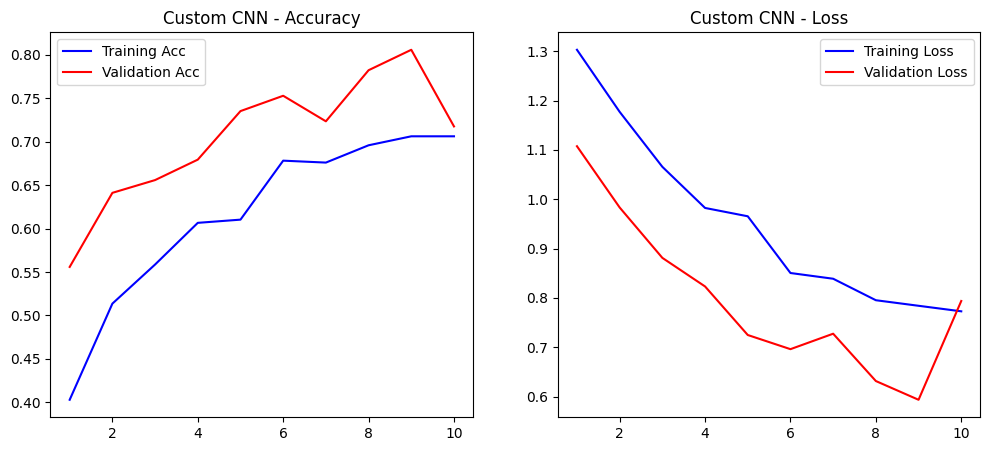

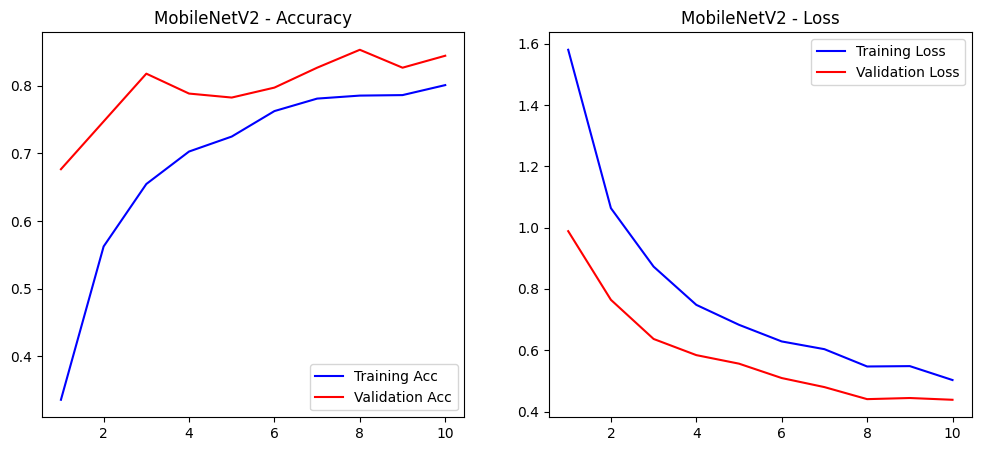

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.show()

plot_history(history, "Custom CNN")
plot_history(history_mobilenet, "MobileNetV2")


## 2. Confusion Matrix & Classification Report

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
              precision    recall  f1-score   support

      glioma       0.29      0.27      0.28       113
  meningioma       0.10      0.07      0.08        72
    no_tumor       0.20      0.19      0.20        67
   pituitary       0.25      0.34      0.29        88

    accuracy                           0.23       340
   macro avg       0.21      0.22      0.21       340
weighted avg       0.22      0.23      0.23       340



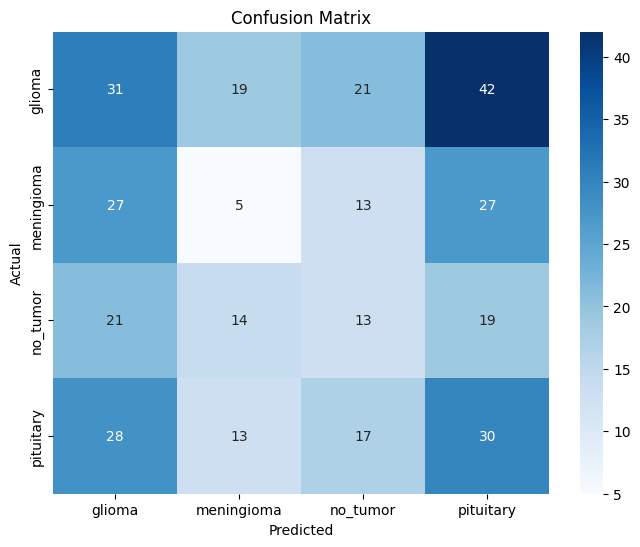

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict on validation data
val_preds = model.predict(val_generator)
pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 8. Model Comparison

| Metric         | Custom CNN   | MobileNetV2 |
| -------------- | ------------ | ----------- |
| Accuracy       | ...          | ...         |
| Loss           | ...          | ...         |
| F1 Score       | ...          | ...         |
| Training Time  | ⏱️           | ⏱️          |
| Generalization | Overfitting? | Better?     |


# 9. Streamlit Deployment

In [12]:
!pip install -q streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [25]:
!pip install streamlit --quiet


In [26]:
!apt install nodejs npm -y
!npm install -g localtunnel


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js
  libjs-inherits libjs-is-typedarray libjs-psl libjs-source-map
  libjs-sprintf-js libjs-typedarray-to-buffer libnode-dev libnode72
  libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy
  node-are-we-there-yet node-argparse node-arrify node-asap node-asynckit
  node-balanced-match node-brace-expansion node-builtins node-cacache
  node-chalk node-chownr node-clean-yaml-object node-cli-table node-clone
  node-color-convert node-color-name node-colors node-columnify
  node-combined-stream node-commander node-console-control-strings
  node-copy-concurrently node-core-util-is node-coveralls node-cssom
  node-cssstyle node-debug node-decompress-response node-defaults
  node-delayed-st

In [28]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import os

# Set title
st.title("Brain Tumor MRI Image Classification")

# Image size (must match training input)
IMG_SIZE = 224

# Load model
@st.cache_resource
def load_cnn_model():
    model = load_model("brain_tumor_model.h5")  # Ensure you renamed your model like this
    return model

model = load_cnn_model()

# Class labels - make sure these match your training classes
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Upload image
uploaded_file = st.file_uploader("Upload a brain MRI image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Show uploaded image
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded Image', use_column_width=True)

    # Predict button
    if st.button("Predict"):
        # Preprocess
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Predict
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions)
        confidence = np.max(predictions)

        # Show result
        st.markdown(f"### 🧠 Prediction: `{class_names[class_index]}`")
        st.markdown(f"Confidence: **{confidence * 100:.2f}%**")

Overwriting app.py


In [29]:
# Save the MobileNetV2 model
model.save("brain_tumor_model.h5")
print("MobileNetV2 model saved as brain_tumor_model.h5")

MobileNetV2 model saved as brain_tumor_model.h5


In [30]:
# Launch in background
!streamlit run /content/app.py &

# Wait 5–10 seconds then expose using localtunnel
!npx localtunnel --port 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.18.82:8501

  Stopping...
your url is: https://moody-heads-shine.loca.lt
^C
